In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
class BGPRouter:
    def __init__(self, as_number):
        self.as_number = as_number
        self.neighbors = []
        self.routing_table = {}
        self.routing_table[as_number] = ([as_number], 0)
    
    def add_neighbor(self, neighbor_as):
        if neighbor_as not in self.neighbors:
            self.neighbors.append(neighbor_as)
    
    def update_routing_table(self, dest_as, path, cost):
        if self.as_number in path:
            return False
        
        new_path = [self.as_number] + path
        new_cost = cost + 1
        
        if dest_as not in self.routing_table:
            self.routing_table[dest_as] = (new_path, new_cost)
            return True
        else:
            current_path, current_cost = self.routing_table[dest_as]
            
            if new_cost < current_cost:
                self.routing_table[dest_as] = (new_path, new_cost)
                return True
            elif new_cost == current_cost and len(new_path) < len(current_path):
                self.routing_table[dest_as] = (new_path, new_cost)
                return True
        
        return False
    
    def get_routes(self):
        return self.routing_table.copy()
    
    def display_routing_table(self):
        print(f"\nBGP Routing Table for AS {self.as_number}:")
        print("-" * 70)
        print(f"{'Destination AS':<20} {'AS Path':<35} {'Path Length':<15}")
        print("-" * 70)
        for dest_as in sorted(self.routing_table.keys()):
            path, cost = self.routing_table[dest_as]
            path_str = ' -> '.join(map(str, path))
            print(f"{dest_as:<20} {path_str:<35} {len(path)-1:<15}")
        print("-" * 70)

In [4]:
def simulate_bgp(as_topology):
    routers = {}
    
    all_as = set()
    for as_num in as_topology.keys():
        all_as.add(as_num)
    for as_num, neighbors in as_topology.items():
        for neighbor in neighbors:
            all_as.add(neighbor)
    
    for as_num in all_as:
        routers[as_num] = BGPRouter(as_num)
    
    for as_num, neighbors in as_topology.items():
        for neighbor in neighbors:
            routers[as_num].add_neighbor(neighbor)
            if neighbor in routers:
                routers[neighbor].add_neighbor(as_num)
    
    print("Starting BGP Simulation...")
    print("=" * 70)
    print("\nAS Topology:")
    for as_num in sorted(routers.keys()):
        neighbors = ', '.join(map(str, sorted(routers[as_num].neighbors)))
        print(f"AS {as_num} peers with: {neighbors}")
    
    max_iterations = 20
    iteration = 0
    
    print("\n" + "=" * 70)
    print("BGP UPDATE Message Exchange")
    print("=" * 70)
    
    while iteration < max_iterations:
        iteration += 1
        updated = False
        
        print(f"\n--- Round {iteration} ---")
        
        for as_num, router in routers.items():
            routes = router.get_routes()
            
            for neighbor_as in router.neighbors:
                if neighbor_as in routers:
                    for dest_as, (path, cost) in routes.items():
                        if dest_as != neighbor_as:
                            if routers[neighbor_as].update_routing_table(dest_as, path, cost):
                                updated = True
                                print(f"AS {as_num} -> AS {neighbor_as}: Route to AS {dest_as} via {path}")
        
        if not updated:
            print(f"\nBGP Converged after {iteration} rounds!")
            break
    
    print("\n" + "=" * 70)
    print("FINAL BGP ROUTING TABLES")
    print("=" * 70)
    
    for as_num in sorted(routers.keys()):
        routers[as_num].display_routing_table()
    
    return routers

In [5]:
def visualize_as_topology(as_topology):
    G = nx.Graph()
    
    for as_num, neighbors in as_topology.items():
        for neighbor in neighbors:
            G.add_edge(f"AS{as_num}", f"AS{neighbor}")
    
    pos = nx.spring_layout(G, seed=42, k=2)
    plt.figure(figsize=(14, 10))
    
    nx.draw_networkx_nodes(G, pos, node_color='lightyellow', 
                          node_size=2000, alpha=0.9, 
                          edgecolors='black', linewidths=2)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=3, alpha=0.6, edge_color='blue')
    
    plt.title("BGP Autonomous System Topology", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
def visualize_as_path(routers, source_as, dest_as):
    if dest_as not in routers[source_as].routing_table:
        print(f"No path from AS {source_as} to AS {dest_as}")
        return
    
    path, cost = routers[source_as].routing_table[dest_as]
    
    G = nx.DiGraph()
    for i in range(len(path) - 1):
        G.add_edge(f"AS{path[i]}", f"AS{path[i+1]}")
    
    all_as = set()
    for router in routers.values():
        all_as.add(f"AS{router.as_number}")
    
    for node in all_as:
        if node not in G.nodes():
            G.add_node(node)
    
    pos = nx.spring_layout(G, seed=42, k=2)
    plt.figure(figsize=(12, 8))
    
    node_colors = ['lightgreen' if node == f"AS{source_as}" 
                   else 'lightcoral' if node == f"AS{dest_as}"
                   else 'lightyellow' for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=2000, alpha=0.9,
                          edgecolors='black', linewidths=2)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')
    
    path_edges = [(f"AS{path[i]}", f"AS{path[i+1]}") for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, path_edges, width=4, alpha=0.8, 
                          edge_color='red', arrows=True, 
                          arrowsize=20, arrowstyle='->')
    
    plt.title(f"AS Path from AS{source_as} to AS{dest_as}\nPath: {' -> '.join(map(str, path))}", 
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

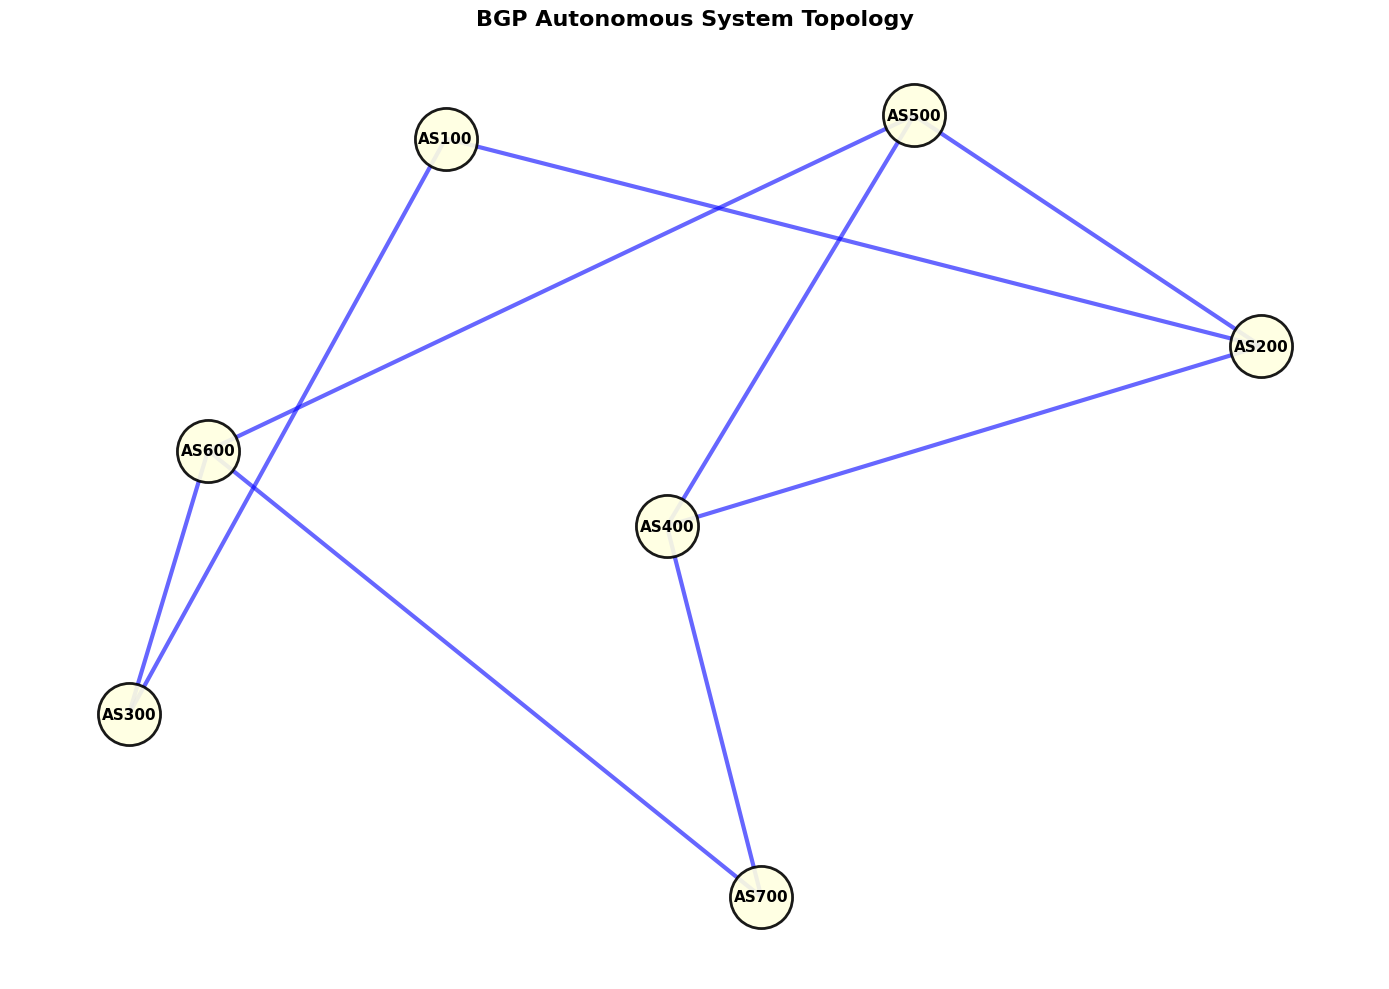

In [7]:
as_topology = {
    100: [200, 300],
    200: [100, 400, 500],
    300: [100, 600],
    400: [200, 500, 700],
    500: [200, 400, 600],
    600: [300, 500, 700],
    700: [400, 600]
}

visualize_as_topology(as_topology)

In [8]:
routers = simulate_bgp(as_topology)

Starting BGP Simulation...

AS Topology:
AS 100 peers with: 200, 300
AS 200 peers with: 100, 400, 500
AS 300 peers with: 100, 600
AS 400 peers with: 200, 500, 700
AS 500 peers with: 200, 400, 600
AS 600 peers with: 300, 500, 700
AS 700 peers with: 400, 600

BGP UPDATE Message Exchange

--- Round 1 ---
AS 100 -> AS 200: Route to AS 100 via [100]
AS 100 -> AS 300: Route to AS 100 via [100]
AS 200 -> AS 100: Route to AS 200 via [200]
AS 200 -> AS 400: Route to AS 200 via [200]
AS 200 -> AS 400: Route to AS 100 via [200, 100]
AS 200 -> AS 500: Route to AS 200 via [200]
AS 200 -> AS 500: Route to AS 100 via [200, 100]
AS 300 -> AS 100: Route to AS 300 via [300]
AS 300 -> AS 600: Route to AS 300 via [300]
AS 300 -> AS 600: Route to AS 100 via [300, 100]
AS 400 -> AS 200: Route to AS 400 via [400]
AS 400 -> AS 500: Route to AS 400 via [400]
AS 400 -> AS 700: Route to AS 400 via [400]
AS 400 -> AS 700: Route to AS 200 via [400, 200]
AS 400 -> AS 700: Route to AS 100 via [400, 200, 100]
AS 500 

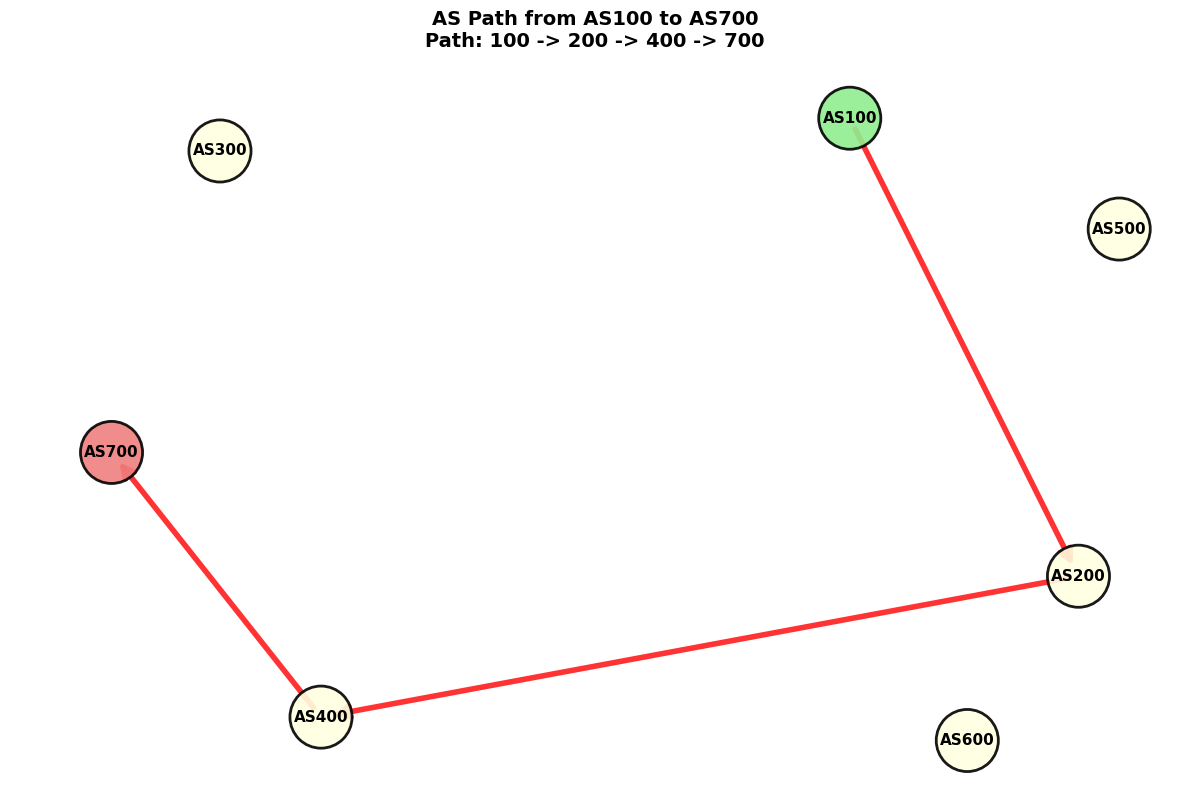

In [9]:
visualize_as_path(routers, 100, 700)

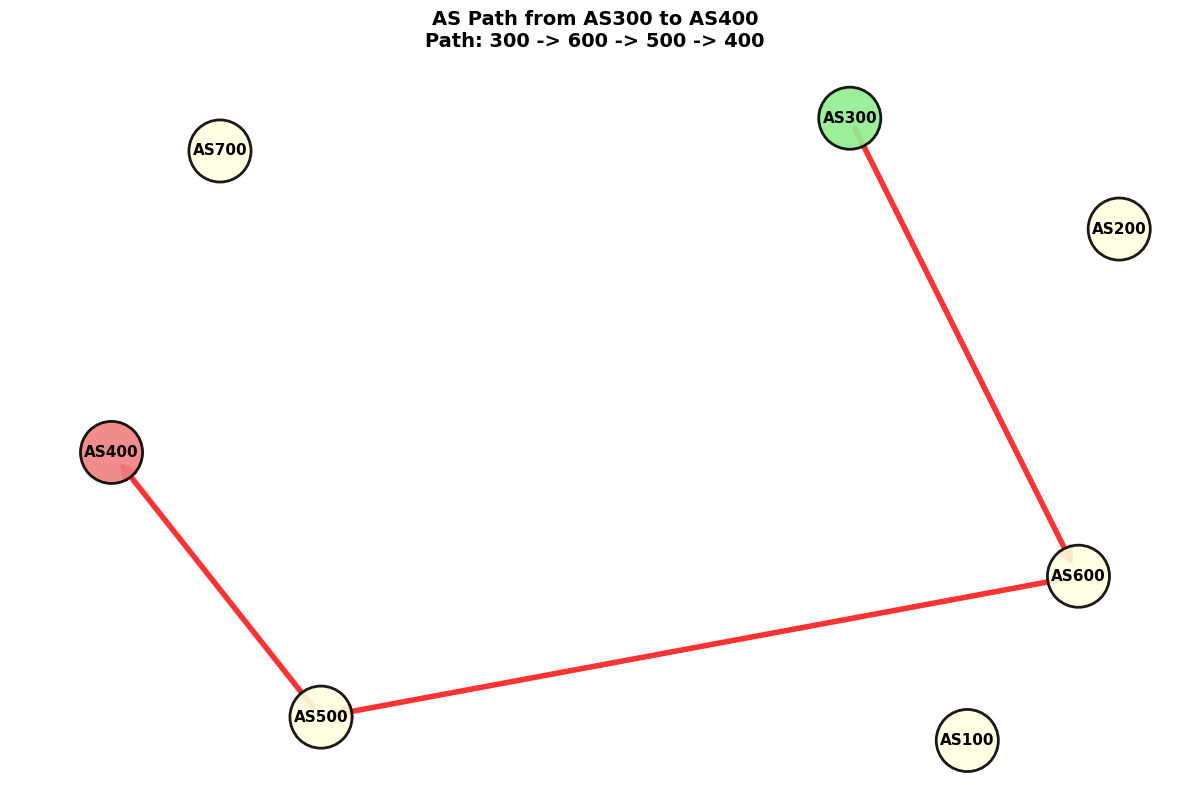

In [10]:
visualize_as_path(routers, 300, 400)